In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from data.dataset import FastInpaintBMELDataset, MoonCometInpaintDataset, MoonCometBoneInpaintDataset
from torch.utils.data import DataLoader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import tqdm
import os

import core.praser as Praser
from models.network import Network


In [3]:
DEVICE = 'cuda:2'
EPOCH = 300
EMA = '_ema'
ROOT = 'experiments/'
ROOT += 'train_boneinpainting_fastmri_e4_quad_230822_211308/'
SAVE = ROOT+'preds/'
os.makedirs(SAVE,mode=0o755, exist_ok=True)
print(f"saving to {SAVE}")

args = Namespace(config=ROOT + 'config.json', phase='test', gpu_ids=None, batch=6, debug=False)
opt = Praser.parse_test(args)


saving to experiments/train_boneinpainting_fastmri_e4_quad_230822_211308/preds/


In [4]:

model_args = opt["model"]["which_networks"][0]["args"]
model = Network(**model_args)
model_pth = Path(ROOT) / 'checkpoint' / f'{EPOCH}_Network{EMA}.pth'
state_dict = torch.load(model_pth)
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.set_new_noise_schedule(device=DEVICE, phase='test')


In [5]:

ds = MoonCometBoneInpaintDataset(clean=True, bmel=True)
ds.slices = [d for d in ds.slices if d['BMELT'][d['BMELT'] != 3].sum() > 0]
for slc in ds.slices:
    slc['BMELT'][slc['BMELT'] == 3] = 0
    slc['BMELT'][slc['BMELT'] > 0] = 1

dl = DataLoader(ds, batch_size=args.batch)


SliceDataset.tx: 100%|██████████| 33/33 [00:18<00:00,  1.78it/s]


sampling loop time step: 100%|██████████| 1000/1000 [04:32<00:00,  3.66it/s]


saved to experiments/train_boneinpainting_fastmri_e4_quad_230822_211308/preds/comet-patient-ccf-006-20221004-knee-slc06.pt
saved to experiments/train_boneinpainting_fastmri_e4_quad_230822_211308/preds/comet-patient-ccf-006-20221004-knee-slc07.pt
saved to experiments/train_boneinpainting_fastmri_e4_quad_230822_211308/preds/comet-patient-ccf-006-20221004-knee-slc09.pt
saved to experiments/train_boneinpainting_fastmri_e4_quad_230822_211308/preds/comet-patient-ccf-006-20221004-knee-slc10.pt
saved to experiments/train_boneinpainting_fastmri_e4_quad_230822_211308/preds/comet-patient-ccf-006-20221004-knee-slc11.pt
saved to experiments/train_boneinpainting_fastmri_e4_quad_230822_211308/preds/comet-patient-ccf-006-20221004-knee-slc13.pt


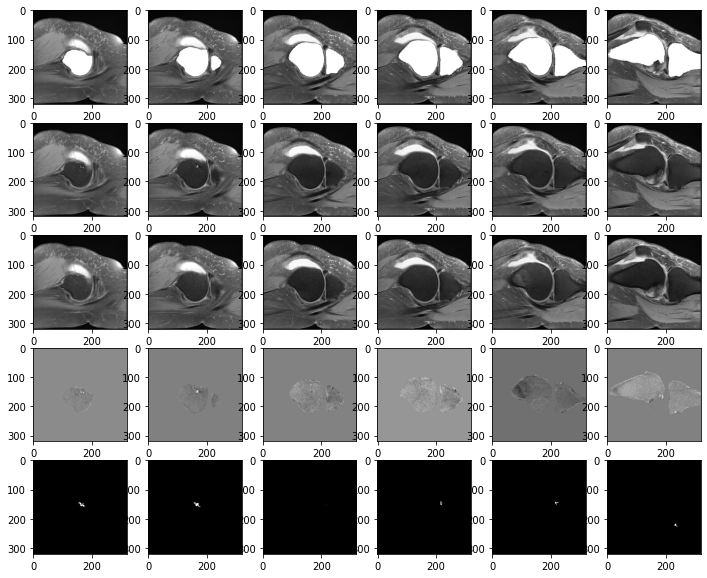

  0%|          | 0/39 [04:35<?, ?it/s]


In [6]:

ret = {}
for batch in tqdm.tqdm(dl):
    batch_size = len(batch['path'])
    model.output, model.visuals = model.restoration(
        batch['cond_image'].to(DEVICE),
        y_t=batch['cond_image'].to(DEVICE),
        y_0=batch['gt_image'].to(DEVICE),
        mask=batch['mask'].to(DEVICE),
        sample_num=8
    )

    fig, ax = plt.subplots(5, batch_size, figsize=(10 * batch_size / 5, 10))
    for ndx in range(batch_size):
        sample = {
            'gt': batch['gt_image'][ndx,0],
            'pred': model.output[ndx,0].cpu(),
            'bmel': batch['bmel'][ndx,0].cpu(),
            'mask': batch['mask'][ndx,0]
        }
        ret[batch['path'][ndx]] = sample
        savepath = SAVE + batch['path'][ndx].replace('png','pt')
        # torch.save(sample['pred'], savepath)
        print(f"saved to {savepath}")
        im = ax[0,ndx].imshow(batch['mask_image'][ndx,0], 'gray')
        # plt.colorbar(im, ax=ax[0,ndx])
        im = ax[1,ndx].imshow(batch['gt_image'][ndx,0], 'gray')
        # plt.colorbar(im, ax=ax[1,ndx])
        im = ax[2,ndx].imshow(model.output[ndx,0].cpu(), 'gray')
        # plt.colorbar(im, ax=ax[2,ndx])
        im = ax[3,ndx].imshow(batch['gt_image'][ndx,0] - model.output[ndx,0].cpu(), 'gray')
        im = ax[4,ndx].imshow(batch['bmel'][ndx,0], 'gray')
    plt.show()
    break